# Part 4: Quantization

## Load Cifar10 dataset from tf.keras

In [4]:
import tensorflow as tf
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

### Let's print some information about the dataset
Print the the dataset shape

In [5]:
print(x_train.shape, x_test.shape,y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 10) (10000, 10)


## Construct a model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and recently support for QKeras model is added to hls4ml.

In [50]:
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.qconvolutional import QConv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Flatten,InputLayer, MaxPooling2D, Activation

model = Sequential()
input_shape = (32, 32, 3)
model.add(InputLayer(input_shape=input_shape))
model.add(QConv2D(16, kernel_size=(3, 3),kernel_quantizer=quantized_bits(6,0,alpha=1),  bias_quantizer=quantized_bits(6,0,alpha=1)))
model.add(QActivation(activation=quantized_relu(6)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(QConv2D(16, kernel_size=(3, 3),kernel_quantizer=quantized_bits(6,0,alpha=1),  bias_quantizer=quantized_bits(6,0,alpha=1)))
model.add(QActivation(activation=quantized_relu(6)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(QConv2D(16, kernel_size=(3, 3),kernel_quantizer=quantized_bits(6,0,alpha=1),  bias_quantizer=quantized_bits(6,0,alpha=1)))
model.add(QActivation(activation=quantized_relu(6)))
model.add(Flatten())
model.add(QDense(10,kernel_quantizer=quantized_bits(6,0,alpha=1),  bias_quantizer=quantized_bits(6,0,alpha=1)))
model.add(Activation(activation='softmax'))

model.build()
model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_conv2d_29 (QConv2D)        (None, 30, 30, 16)        448       
_________________________________________________________________
q_activation_28 (QActivation (None, 30, 30, 16)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
q_conv2d_30 (QConv2D)        (None, 13, 13, 16)        2320      
_________________________________________________________________
q_activation_29 (QActivation (None, 13, 13, 16)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
q_conv2d_31 (QConv2D)        (None, 4, 4, 16)        

## Train sparse
Let's train with model sparsity again, since QKeras layers are prunable.

In [51]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.8, begin_step=0, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)


## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_mnist_cnn4'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [52]:
from tensorflow.keras.optimizers import Adam
from callbacks import all_callbacks

train =True


if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_cifar10_cnn4')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(x_train, y_train, batch_size=128,
              epochs=100, validation_split=0.2, shuffle=True,
              callbacks = callbacks.callbacks)
    model = strip_pruning(model)
    model.save('model_cifar10_cnn4/KERAS_check_best_model.h5')
else:
    from qkeras.utils import load_qmodel
    model = load_qmodel('model_cifar10_cnn4/KERAS_check_best_model.h5')

2021-11-28 08:01:04.800490: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


Epoch 1/100
  1/313 [..............................] - ETA: 0s - loss: 2.5423 - accuracy: 0.1016

2021-11-28 08:01:09.472027: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 10/313 [..............................] - ETA: 15s - loss: 2.5208 - accuracy: 0.0969

2021-11-28 08:01:09.685286: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: model_cifar10_cnn4/logs/train/plugins/profile/2021_11_28_08_01_09
2021-11-28 08:01:09.698349: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to model_cifar10_cnn4/logs/train/plugins/profile/2021_11_28_08_01_09/ECE-util1.trace.json.gz
2021-11-28 08:01:09.716683: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: model_cifar10_cnn4/logs/train/plugins/profile/2021_11_28_08_01_09
2021-11-28 08:01:09.724079: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to model_cifar10_cnn4/logs/train/plugins/profile/2021_11_28_08_01_09/ECE-util1.memory_profile.json.gz
2021-11-28 08:01:09.783572: I tensorflow/python/profiler/internal/profiler_wrapper.cc:111] Creating directory: model_cifar10_cnn4/logs/train/plugins/profile/2021_11_28_08_01_09Dumped tool da

312/313 [============================>.] - ETA: 0s - loss: 2.3239 - accuracy: 0.0932
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00001: val_loss improved from inf to 2.29608, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 2.29608, saving model to model_cifar10_cnn4/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_cifar10_cnn4/KERAS_check_model_last.h5

Epoch 00001: saving model to model_cifar10_cnn4/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 8s 26ms/step - loss: 2.3238 - accuracy: 0.0933 - val_loss: 2.2961 - val_accuracy: 0.1053
Epoch 2/100
311/313 [============================>.] - ETA: 0s - loss: 2.2873 - accuracy: 0.1238
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00002: val_loss improved from 2.29608 to 2.27424, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epoch 00002: val_loss imp

Epoch 13/100
312/313 [============================>.] - ETA: 0s - loss: 1.8385 - accuracy: 0.3373
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00013: val_loss improved from 1.85236 to 1.82984, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epoch 00013: val_loss improved from 1.85236 to 1.82984, saving model to model_cifar10_cnn4/KERAS_check_best_model_weights.h5

Epoch 00013: saving model to model_cifar10_cnn4/KERAS_check_model_last.h5

Epoch 00013: saving model to model_cifar10_cnn4/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 6s 20ms/step - loss: 1.8386 - accuracy: 0.3374 - val_loss: 1.8298 - val_accuracy: 0.3355
Epoch 14/100
313/313 [==============================] - ETA: 0s - loss: 1.8183 - accuracy: 0.3449
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00014: val_loss improved from 1.82984 to 1.81436, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epo

Epoch 25/100
312/313 [============================>.] - ETA: 0s - loss: 1.7001 - accuracy: 0.3839
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00025: val_loss improved from 1.71049 to 1.70277, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epoch 00025: val_loss improved from 1.71049 to 1.70277, saving model to model_cifar10_cnn4/KERAS_check_best_model_weights.h5

Epoch 00025: saving model to model_cifar10_cnn4/KERAS_check_model_last.h5

Epoch 00025: saving model to model_cifar10_cnn4/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 6s 19ms/step - loss: 1.7000 - accuracy: 0.3838 - val_loss: 1.7028 - val_accuracy: 0.3799
Epoch 26/100
311/313 [============================>.] - ETA: 0s - loss: 1.6928 - accuracy: 0.3851
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00026: val_loss improved from 1.70277 to 1.69540, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epo

Epoch 37/100
310/313 [============================>.] - ETA: 0s - loss: 1.6278 - accuracy: 0.4079
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00037: val_loss improved from 1.63819 to 1.63537, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epoch 00037: val_loss improved from 1.63819 to 1.63537, saving model to model_cifar10_cnn4/KERAS_check_best_model_weights.h5

Epoch 00037: saving model to model_cifar10_cnn4/KERAS_check_model_last.h5

Epoch 00037: saving model to model_cifar10_cnn4/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 6s 19ms/step - loss: 1.6282 - accuracy: 0.4078 - val_loss: 1.6354 - val_accuracy: 0.4102
Epoch 38/100
312/313 [============================>.] - ETA: 0s - loss: 1.6255 - accuracy: 0.4110
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00038: val_loss did not improve from 1.63537

Epoch 00038: val_loss did not improve from 1.63537

Epoch 00038: savi

Epoch 49/100
311/313 [============================>.] - ETA: 0s - loss: 1.5785 - accuracy: 0.4279
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00049: val_loss improved from 1.59188 to 1.59178, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epoch 00049: val_loss improved from 1.59188 to 1.59178, saving model to model_cifar10_cnn4/KERAS_check_best_model_weights.h5

Epoch 00049: saving model to model_cifar10_cnn4/KERAS_check_model_last.h5

Epoch 00049: saving model to model_cifar10_cnn4/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 6s 19ms/step - loss: 1.5787 - accuracy: 0.4279 - val_loss: 1.5918 - val_accuracy: 0.4275
Epoch 50/100
311/313 [============================>.] - ETA: 0s - loss: 1.5762 - accuracy: 0.4298
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00050: val_loss improved from 1.59178 to 1.58509, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epo

Epoch 61/100
313/313 [==============================] - ETA: 0s - loss: 1.5394 - accuracy: 0.4436
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00061: val_loss improved from 1.55801 to 1.55166, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epoch 00061: val_loss improved from 1.55801 to 1.55166, saving model to model_cifar10_cnn4/KERAS_check_best_model_weights.h5

Epoch 00061: saving model to model_cifar10_cnn4/KERAS_check_model_last.h5

Epoch 00061: saving model to model_cifar10_cnn4/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 6s 19ms/step - loss: 1.5394 - accuracy: 0.4436 - val_loss: 1.5517 - val_accuracy: 0.4386
Epoch 62/100
311/313 [============================>.] - ETA: 0s - loss: 1.5365 - accuracy: 0.4452
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00062: val_loss improved from 1.55166 to 1.54644, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epo

312/313 [============================>.] - ETA: 0s - loss: 1.4776 - accuracy: 0.4686
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00085: val_loss did not improve from 1.49534

Epoch 00085: val_loss did not improve from 1.49534

Epoch 00085: saving model to model_cifar10_cnn4/KERAS_check_model_last.h5

Epoch 00085: saving model to model_cifar10_cnn4/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 6s 19ms/step - loss: 1.4774 - accuracy: 0.4686 - val_loss: 1.5007 - val_accuracy: 0.4561
Epoch 86/100
313/313 [==============================] - ETA: 0s - loss: 1.4759 - accuracy: 0.4687
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00086: val_loss improved from 1.49534 to 1.48919, saving model to model_cifar10_cnn4/KERAS_check_best_model.h5

Epoch 00086: val_loss improved from 1.49534 to 1.48919, saving model to model_cifar10_cnn4/KERAS_check_best_model_weights.h5

Epoch 00086: saving model to m

Epoch 97/100
313/313 [==============================] - ETA: 0s - loss: 1.4528 - accuracy: 0.4782
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00097: val_loss did not improve from 1.47012

Epoch 00097: val_loss did not improve from 1.47012

Epoch 00097: saving model to model_cifar10_cnn4/KERAS_check_model_last.h5

Epoch 00097: saving model to model_cifar10_cnn4/KERAS_check_model_last_weights.h5

***callbacks end***

313/313 [==============================] - 6s 19ms/step - loss: 1.4528 - accuracy: 0.4782 - val_loss: 1.4757 - val_accuracy: 0.4678
Epoch 98/100
312/313 [============================>.] - ETA: 0s - loss: 1.4503 - accuracy: 0.4771
***callbacks***
saving losses to model_cifar10_cnn4/losses.log

Epoch 00098: val_loss did not improve from 1.47012

Epoch 00098: val_loss did not improve from 1.47012

Epoch 00098: saving model to model_cifar10_cnn4/KERAS_check_model_last.h5

Epoch 00098: saving model to model_cifar10_cnn4/KERAS_check_model_last_weights.h5


## Check performance
How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model? Let's report the accuracy and make a ROC curve. The quantized, pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.


We should also check that hls4ml can respect the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a configuration from this Quantized model, and plot its performance as the dotted line.
The generated configuration is printed out. You'll notice that it uses 7 bits for the type, but we specified 6!? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers to round, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations. And we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.


**Make sure you've trained the model from part 1**

In [54]:
import hls4ml
from hls4ml.converters.keras_to_hls import keras_to_hls
import plotting
import yaml

hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'



config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['Backend']='VivadoAccelerator'
config['OutputDir'] = 'cifar10-hls-test4'
config['ProjectName'] = 'myproject_cifar10_cnn4'
config['XilinxPart']= 'xczu7ev-ffvc1156-2-e'
config['Board'] = 'zcu104'
config['ClockPeriod'] = 5
config['IOType'] = 'io_stream'
config['HLSConfig']={}
config['HLSConfig']['Model']={}
config['HLSConfig']['Model']=config['Model']
config['HLSConfig']['LayerName']=config['LayerName']

del config['Model']
del config['LayerName']
config['AcceleratorConfig']={}
config['AcceleratorConfig']['Interface'] = 'axi_stream'
config['AcceleratorConfig']['Driver'] = 'python'
config['AcceleratorConfig']['Precision']={}
config['AcceleratorConfig']['Precision']['Input']= 'float'
config['AcceleratorConfig']['Precision']['Output']= 'float'
config['KerasModel'] = model
config['HLSConfig']['LayerName']['q_conv2d_29']['ReuseFactor'] = 8
config['HLSConfig']['LayerName']['q_conv2d_30']['ReuseFactor'] = 8
config['HLSConfig']['LayerName']['q_conv2d_31']['ReuseFactor'] = 8
config['HLSConfig']['LayerName']['q_dense_11']['ReuseFactor'] = 8

print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = keras_to_hls(config)
hls_model.compile()
y_qkeras = model.predict(x_test)
x_test = np.ascontiguousarray(x_test)
y_hls = hls_model.predict(x_test)

Interpreting Sequential
Topology:
Layer name: input_11, layer type: Input
Layer name: q_conv2d_29, layer type: QConv2D
Layer name: q_activation_28, layer type: QActivation
Layer name: max_pooling2d_20, layer type: MaxPooling2D
Layer name: q_conv2d_30, layer type: QConv2D
Layer name: q_activation_29, layer type: QActivation
Layer name: max_pooling2d_21, layer type: MaxPooling2D
Layer name: q_conv2d_31, layer type: QConv2D
Layer name: q_activation_30, layer type: QActivation
Layer name: q_dense_11, layer type: QDense
Layer name: activation_10, layer type: Activation
-----------------------------------
Configuration
Backend:             VivadoAccelerator
OutputDir:           cifar10-hls-test4
ProjectName:         myproject_cifar10_cnn4
XilinxPart:          xczu7ev-ffvc1156-2-e
Board:               zcu104
ClockPeriod:         5
IOType:              io_stream
HLSConfig
  Model
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    Strategy:        Latency
  LayerName
    input_11
  

In [59]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_cifar10_cnn/KERAS_check_best_model.h5')
y_ref = model_ref.predict(x_test)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))


Accuracy baseline:  0.6667
Accuracy pruned, quantized: 0.4678
Accuracy hls4ml: 0.4664


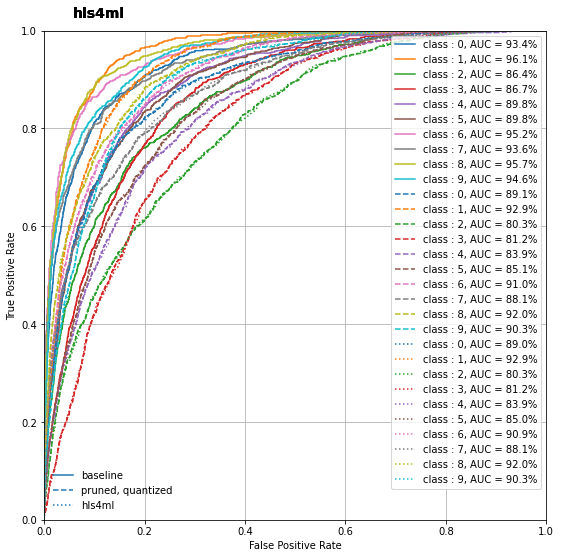

In [56]:
import matplotlib.pyplot as plt
cifar10_classes=['0','1','2','3','4','5','6','7','8','9']

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, cifar10_classes)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, cifar10_classes, linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls,cifar10_classes, linestyle=':')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'],
            loc='lower left', frameon=False)
ax.add_artist(leg)

# Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f mnist-hls-test4/vivado_hls.log`

In [57]:
import os
os.environ['PATH'] = '/workspace/home/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
hls_model.build(csim=False,synth=True,export=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /workspace/home/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/workspace/home/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
/workspace/home/Xilinx/Vivado/2019.2/tps/tcl/tcl8.5/tzdata/America/Denver can't be opened.
INFO: [HLS 200-10] For user 'vitis-ai-user' on host 'eceutil1.gpu.snuhpc' (Linux_x86_64 version 4.15.0-76-generic) on Sun Nov 28 08:22:52 MST 2021
INFO: [HLS 200-10] On os Ubuntu 18.04.5 LTS
INFO: [HLS 200-10] In directory '/workspace/home/ymli/cifar_10_hls4ml/cifar10-hls-test4'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/workspace/home/ymli/cifar_10_hls4ml/cifar10-hls-test4/myproject_cifar10_cnn4_prj'.
INFO: [HLS 200-10] Adding design 

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[]' into 'nnet::compute_pool_buffer_2d<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>' (firmware/nnet_utils/nnet_pooling_stream.h:195).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[]' into 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' (firmware/nnet_utils/nnet_conv_stream.h:284).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[]' into 'nnet::compute_pool_buffer_2d<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config9>' (firmware/nnet_ut

INFO: [XFORM 203-603] Inlining function 'nnet::reduce_pool<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 4, config5>' into 'nnet::compute_pool_buffer_2d<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>' (firmware/nnet_utils/nnet_pooling_stream.h:195).
INFO: [XFORM 203-603] Inlining function 'nnet::compute_pool_buffer_2d<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>' into 'nnet::pooling2d_buffer_cl<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>' (firmware/nnet_utils/nnet_pooling_stream.h:238).
INFO: [XFORM 203-603] Inlining function 'nnet::pooling2d_buffer_cl<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>' into 'nnet::poo

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 10u>::operator[]' into 'nnet::linear<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 10u>, linear_config15>' (firmware/nnet_utils/nnet_activation_stream.h:47).
INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:01:00 ; elapsed = 00:02:46 . Memory (MB): peak = 1082.555 ; gain = 651.035 ; free physical = 1556 ; free virtual = 168771
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_27088

INFO: [SYNCHK 200-10] 0 error(s), 1 warning(s).
INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:01:03 ; elapsed = 00:02:49 . Memory (MB): peak = 1087.297 ; gain = 655.777 ; free physical = 1509 ; free virtual = 168730
INFO: [XFORM 203-1101] Packing variable 'out_pack.data.V' (firmware/nnet_utils/nnet_activation_stream.h:170) into a 160-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:64) into a 96-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:64) into a 96-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:64) into a 96-bit variable.
INFO: [XFORM 203-1101] Packing variable 'res_pack.data.V' (firmware/nnet_utils/nnet_pooling_stream.h:178) into a 256-bit variable.
INFO: [XFORM 203-1101] Packing variable 'res_pack.data.V' (firmware/nnet_utils/nnet_pooling_str

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config10>' (firmware/nnet_utils/nnet_conv_stream.h:187:82).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, config9>' (firmware/nnet_utils/nnet_conv_stream.h:187:82).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' (firmware/nnet_utils/nnet_conv_stream.h:187:82).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, config5>' (firmware/nnet_utils/nnet_conv_stream.h:187:82).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:120) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'CastLoop' (firmware/nnet_utils/nnet_conv_stream.h:282) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-1.1.1' (firmware/nnet_utils/nnet_conv_stream.h:258) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 143.
INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:85) in function 'nnet::con

INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (firmware/nnet_utils/nnet_conv_stream.h:199) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config10>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelPushChannel' (firmware/nnet_utils/nnet_conv_stream.h:201) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config10>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:219) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, config9>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:226) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, config9>' completely with a factor of 16.
INFO: [HLS 200-489] Unrollin

INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer3_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:64) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer4_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:68) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer11_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:96) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer9_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:88) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer5_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:72) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer6_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:76) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer2_out.V.data.V' (firmware/myproject_cifar10_cnn4.cpp:60) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer10_out.V.data.V' (firmware

INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:216) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:216) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:216) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:216) in dimension 2 completely.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/

INFO: [XFORM 203-602] Inlining function 'nnet::softmax_idx_from_real_val<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, softmax_config16>' into 'nnet::softmax_latency<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 10u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, softmax_config16>' (firmware/nnet_utils/nnet_activation_stream.h:166) automatically.
INFO: [XFORM 203-721] Changing loop 'Loop_1_proc' (firmware/myproject_cifar10_cnn4_axi.cpp:23) to a process function for dataflow in function 'myproject_cifar10_cnn4_axi'.
INFO: [XFORM 203-721] Changing loop 'Loop_2_proc' (firmware/myproject_cifar10_cnn4_axi.cpp:37) to a process function for dataflow in function 'myproject_cifar10_cnn4_axi'.
INFO: [XFORM 203-712] Applying dataflow to function 'myproject_cifar10_cnn4', detected/extracted 16 process function(s): 
	 'myproject_cifar10_cnn4_Block__proc'
	 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 

INFO: [XFORM 203-11] Balancing expressions in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' (firmware/nnet_utils/nnet_conv_stream.h:45:5)...452 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config10>' (firmware/nnet_utils/nnet_conv_stream.h:45:5)...448 expression(s) balanced.
INFO: [HLS 200-111] Finished Pre-synthesis Time (s): cpu = 00:08:06 ; elapsed = 00:10:11 . Memory (MB): peak = 10322.594 ; gain = 9891.074 ; free physical = 4959 ; free virtual = 164127
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_pooling_stream.h:233:80) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<6, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed

INFO: [HLS 200-472] Inferring partial write operation for 'out_data.data.V' (firmware/nnet_utils/nnet_stream.h:88:42)
INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:09:26 ; elapsed = 00:11:33 . Memory (MB): peak = 10322.594 ; gain = 9891.074 ; free physical = 4958 ; free virtual = 164123
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject_cifar10_cnn4_axi' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'Loop_1_proc459' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 693.94 seconds; current allocated memory: 782.506 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sha

INFO: [SCHED 204-61] Pipelining loop 'ReLUActLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 3.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.6 seconds; current allocated memory: 789.663 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.32 seconds; current allocated memory: 791.448 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'shift_line_buffer_array_ap_fixed_16u_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'shift_line_buffer<array<ap_fixed,16u>,

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'shift_line_buffer_array_ap_fixed_16u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'shift_line_buffer<array<ap_fixed,16u>,config10>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.37 seconds; current allocated memory: 827.796 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.9 seconds; current allocated memory: 828.877 MB.
INFO: [HLS 200-10] --------------------

INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.42 seconds; current allocated memory: 890.967 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.49 seconds; current allocated memory: 891.304 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'softmax_latency_array_array_softmax_config16_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'softmax_latency<array,array,softmax_config16>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 6.
INFO: [SCHED 204-11] Finished scheduling.

INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_array_ap_fixed_16u_config2_s'.
INFO: [HLS 200-111]  Elapsed time: 2.02 seconds; current allocated memory: 931.986 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'linear_array_array_ap_fixed_16u_linear_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'linear_array_array_ap_fixed_16u_linear_config3_s'.
INFO: [HLS 200-111]  Elapsed time: 8.12 seconds; current allocated memory: 941.928 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16u_

INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_fixed_16u_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 4.32 seconds; current allocated memory: 972.054 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config6_s_line_buffer_Array_V_1_0_0' to 'shift_line_buffer_array_ap_fixed_16u_config6_s_line_buffexdS' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config6_s_line_buffer_Array_V_1_1_0' to 'shift_line_buffer_array_ap_fixed_16u_config6_s_line_buffeyd2' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config6_s_line_buffer_Array_V_1_0_1' to 'shift_l

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_array_ap_fixed_16u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------


INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_array_ap_fixed_16u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 10.2 seconds; current allocated memory: 1.043 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'linear_array_array_ap_fixed_16u_linear_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'linear_array_array_ap_fixed_16u_linear_config7_s'.
INFO: [HLS 200-111]  Elapsed time: 45.13 seconds; current allocated memory: 1.091 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16u_rel

INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_fixed_16u_config9_s'.
INFO: [HLS 200-111]  Elapsed time: 5.51 seconds; current allocated memory: 1.120 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config10_s_line_buffer_Array_V_0_0' to 'shift_line_buffer_array_ap_fixed_16u_config10_s_line_buffbjl' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config10_s_line_buffer_Array_V_1381_0' to 'shift_line_buffer_array_ap_fixed_16u_config10_s_line_buffbkl' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16u_config10_s_line_buffer_Array_V_0_1' to 'shift_li

INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_array_ap_fixed_16u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 11.63 seconds; current allocated memory: 1.215 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'linear_array_array_ap_fixed_16u_linear_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'linear_array_array_ap_fixed_16u_linear_config11_s'.
INFO: [HLS 200-111]  Elapsed time: 46.87 seconds; current allocated memory: 1.261 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config12_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16

INFO: [RTGEN 206-100] Finished creating RTL model for 'myproject_cifar10_cnn4_axi'.
INFO: [HLS 200-111]  Elapsed time: 6.75 seconds; current allocated memory: 1.486 GB.
INFO: [HLS 200-790] **** Loop Constraint Status: All loop constraints were satisfied.
INFO: [HLS 200-789] **** Estimated Fmax: 229.93 MHz
INFO: [RTMG 210-278] Implementing memory 'repack_stream_array_array_ap_fixed_256u_256_s_out_data_dabPq_ram (RAM)' using block RAMs.
INFO: [RTMG 210-279] Implementing memory 'softmax_latency_array_array_softmax_config16_s_exp_table1_rom' using block ROMs.
INFO: [RTMG 210-279] Implementing memory 'softmax_latency_array_array_softmax_config16_s_invert_tabbQq_rom' using auto ROMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_0_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_1_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_2_V_U(fifo_w16_d900_A)' using Block RAMs.
INFO: [RTMG 2

INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_11_V_U(fifo_w16_d169_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_12_V_U(fifo_w16_d169_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_13_V_U(fifo_w16_d169_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_14_V_U(fifo_w16_d169_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_15_V_U(fifo_w16_d169_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_0_V_U(fifo_w16_d169_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_1_V_U(fifo_w16_d169_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_2_V_U(fifo_w16_d169_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_3_V_U(fifo_w16_d169_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_4_V_U(fifo_w16_d169_A)' using Block R

INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_11_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_12_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_13_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_14_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_15_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_data_0_V_U(fifo_w6_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_data_1_V_U(fifo_w6_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_data_2_V_U(fifo_w6_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_data_3_V_U(fifo_w6_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_

INFO: [IP_Flow 19-234] Refreshing IP repositories
INFO: [IP_Flow 19-1704] No user IP repositories specified
INFO: [IP_Flow 19-2313] Loaded Vivado IP repository '/workspace/home/Xilinx/Vivado/2019.2/data/ip'.
create_ip: Time (s): cpu = 00:00:04 ; elapsed = 00:00:26 . Memory (MB): peak = 1605.574 ; gain = 93.176 ; free physical = 4862 ; free virtual = 163836
INFO: [IP_Flow 19-1686] Generating 'Synthesis' target for IP 'myproject_cifar10_cnn4_axi_ap_fpext_0_no_dsp_32'...
INFO: [IP_Flow 19-1686] Generating 'Simulation' target for IP 'myproject_cifar10_cnn4_axi_ap_fpext_0_no_dsp_32'...
INFO: [IP_Flow 19-234] Refreshing IP repositories
INFO: [IP_Flow 19-1704] No user IP repositories specified
INFO: [IP_Flow 19-2313] Loaded Vivado IP repository '/workspace/home/Xilinx/Vivado/2019.2/data/ip'.
ipx::update_checksums: Time (s): cpu = 00:00:00.63 ; elapsed = 00:00:22 . Memory (MB): peak = 1608.543 ; gain = 0.000 ; free physical = 4862 ; free virtual = 163839
ipx::archive_core: Time (s): cpu = 00:0

{'EstimatedClockPeriod': '4.349',
 'BestLatency': '14337',
 'WorstLatency': '14337',
 'IntervalMin': '14338',
 'IntervalMax': '14338',
 'BRAM_18K': '147',
 'DSP48E': '140',
 'FF': '36357',
 'LUT': '105271',
 'URAM': '0',
 'AvailableBRAM_18K': '624',
 'AvailableDSP48E': '1728',
 'AvailableFF': '460800',
 'AvailableLUT': '230400',
 'AvailableURAM': '96'}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [58]:
hls4ml.report.read_vivado_report(config['OutputDir'])

Found 1 solution(s) in cifar10-hls-test4/myproject_cifar10_cnn4_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_cifar10_cnn4_axi'
* Date:           Sun Nov 28 08:42:30 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_cifar10_cnn4_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu7ev-ffvc1156-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.349 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-------+-------+----------+
    |  Latency (cycles) |   Latency (absolute)  |    Interval   | Pipeline |
    |   min   |   max   |    min    |    max    |  min

Print the report for the model trained in part 1. Now, compared to the model from part 1, this model has been trained with low-precision quantization, and 75% pruning. You should be able to see that we have saved a lot of resource compared to where we started in part 1. At the same time, referring to the ROC curve above, the model performance is pretty much identical even with this drastic compression!

**Note you need to have trained and synthesized the model from part 1**

In [38]:
hls4ml.report.read_vivado_report('cifar10-hls-test')

Found 1 solution(s) in cifar10-hls-test/myproject_cifar10_cnn_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.


Print the report for the model trained in part 3. Both these models were trained with 75% sparsity, but the new model uses 6-bit precision as well. You can see how Vivado HLS has moved multiplication operations from DSPs into LUTs, reducing the "critical" resource usage.

**Note you need to have trained and synthesized the model from part 3**

In [ ]:
hls4ml.report.read_vivado_report('cifar10-hls-test3')